# Small-signal AC analysis of a silicon PIN photodiode

## Introduction to Small-signal Analysis

Small-Signal AC (SSAC) analysis is a technique used to characterize the frequency-dependent behavior of semiconductor devices under small perturbations around a DC operating point. This method is essential for understanding the high-frequency performance limitations of devices such as photodiodes, modulators, and transistors. We first establish a DC operating point (bias condition) for the device. Then, we apply a small AC voltage perturbation and analyze how the device responds at different frequencies. The analysis assumes that the perturbation is small enough that the device's response remains linear, allowing us to extract frequency-dependent parameters.

The primary output of SSAC analysis is the **small-signal admittance** $ Y(\omega) $, which relates the small-signal current $ I(\omega) $ to the small-signal voltage $ V(\omega) $:

$$
Y(\omega) = \frac{I(\omega)}{V(\omega)} = G(\omega) + j\omega C(\omega)
$$

where:
- $ G(\omega) $ is the **conductance** (real part of admittance), representing resistive losses
- $ C(\omega) $ is the **capacitance** (imaginary part divided by $\omega$), representing charge storage
- $ \omega = 2\pi f $ is the angular frequency

### Goal of this notebook

In this notebook, we will:
1. Set up a reverse-biased silicon PIN photodiode structure
2. Perform SSAC analysis over a range of frequencies
3. Extract and plot the frequency-dependent conductance $ G(f) $ and capacitance $ C(f) $

<img src="img/vertical_pin.png" width="500" alt="Schematic">

## Setup and imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Device and simulation setup

### PIN photodiode structure

We will design a vertical PIN photodiode with the following structure:
- **P+ region**: Heavily doped p-type silicon (top contact)
- **Intrinsic region**: Lightly doped silicon (absorption region)
- **N+ region**: Heavily doped n-type silicon (bottom contact)
- **Metal contacts**: Aluminum electrodes for electrical connection

The device will be operated under reverse bias (negative voltage on p-side), which depletes the intrinsic region and creates a strong electric field for efficient photocarrier collection.


<img src="img/vertical_pin.png" width="500" alt="Vertical pin schematic">


### Geometry definition

First, we define the geometric parameters of our PIN structure. All dimensions are in micrometers (µm).


In [2]:
# Device dimensions (µm)
device_width = 2.0  # Lateral dimension
z_size = 2.0  # Extrusion dimension (for 2D simulation)

# Layer thicknesses
p_thickness = 0.3  # P+ contact layer
i_thickness = 1.0  # Intrinsic absorption region
n_thickness = 0.3  # N+ contact layer
contact_thickness = 0.2  # Metal contact thickness

# Layer centers (stacked vertically along y-axis)
total_height = p_thickness + i_thickness + n_thickness
y_bottom = -total_height / 2

# N+ layer (bottom)
n_center_y = y_bottom + n_thickness / 2
n_center = (0, n_center_y, 0)
n_size = (device_width, n_thickness, z_size)

# Intrinsic layer (middle)
i_center_y = n_center_y + n_thickness / 2 + i_thickness / 2
i_center = (0, i_center_y, 0)
i_size = (device_width, i_thickness, z_size)

# P+ layer (top)
p_center_y = i_center_y + i_thickness / 2 + p_thickness / 2
p_center = (0, p_center_y, 0)
p_size = (device_width, p_thickness, z_size)

# Contact layers
contact_n_y = n_center_y - n_thickness / 2 - contact_thickness / 2
contact_p_y = p_center_y + p_thickness / 2 + contact_thickness / 2

contact_n_center = (0, contact_n_y, 0)
contact_p_center = (0, contact_p_y, 0)
contact_size = (device_width, contact_thickness, z_size)

### Doping profile

Next, we define the doping profiles for the PIN structure. We use:
- **Constant doping** for the lightly doped intrinsic region (background doping)
- **Gaussian doping** for the heavily doped P+ and N+ regions with smooth transitions

The doping concentrations are based on typical values for silicon photodiodes.


In [3]:
# Doping concentrations (cm^-3)
intrinsic_doping = 1e14  # Background doping in intrinsic region
p_plus_doping = 1e19  # P+ contact doping
n_plus_doping = 1e19  # N+ contact doping

# Junction width for Gaussian doping profiles
junction_width = 0.01  # Controls sharpness of doping transition

# Intrinsic region: constant low doping
acceptor_intrinsic = td.ConstantDoping(center=i_center, size=i_size, concentration=intrinsic_doping)

# P+ region: Gaussian acceptor doping
acceptor_p_plus = td.GaussianDoping(
    center=p_center,
    size=p_size,
    concentration=p_plus_doping,
    ref_con=intrinsic_doping,
    width=junction_width,
    source="ymax",  # Doping is constant along ymax plane
)

# N+ region: Gaussian donor doping
donor_n_plus = td.GaussianDoping(
    center=n_center,
    size=n_size,
    concentration=n_plus_doping,
    ref_con=intrinsic_doping,
    width=junction_width,
    source="ymin",  # Doping is constant along ymin plane
)

### Material models

We now define the physical models for silicon. The parameters are based on well-established models from semiconductor device physics literature.

In [4]:
# Electron mobility model (Caughey-Thomas)
mobility_n = td.CaugheyThomasMobility(
    mu=1471.0,  # Maximum mobility (cm²/V·s)
    mu_min=52.2,  # Minimum mobility (cm²/V·s)
    ref_N=9.68e16,  # Reference doping (cm⁻³)
    exp_N=0.68,  # Doping exponent
    exp_1=-0.57,  # Temperature exponent 1
    exp_2=-2.33,  # Temperature exponent 2
    exp_3=2.4,  # Temperature exponent 3
    exp_4=-0.146,  # Temperature exponent 4
)

# Hole mobility model (Caughey-Thomas)
mobility_p = td.CaugheyThomasMobility(
    mu=470.5,  # Maximum mobility (cm²/V·s)
    mu_min=44.9,  # Minimum mobility (cm²/V·s)
    ref_N=2.23e17,  # Reference doping (cm⁻³)
    exp_N=0.719,  # Doping exponent
    exp_1=-0.57,  # Temperature exponent 1
    exp_2=-2.23,  # Temperature exponent 2
    exp_3=2.4,  # Temperature exponent 3
    exp_4=-0.146,  # Temperature exponent 4
)

# Effective density of states (constant for isothermal simulation)
# Values at T=300K from Sze & Ng
N_c = td.ConstantEffectiveDOS(N=2.86e19)  # Conduction band (cm⁻³)
N_v = td.ConstantEffectiveDOS(N=3.1e19)  # Valence band (cm⁻³)

# Energy bandgap at 300K
E_g = td.ConstantEnergyBandGap(eg=1.12)  # Silicon bandgap (eV)

#### Recombination models

We include the major recombination mechanisms in silicon:
- **Shockley-Read-Hall (SRH)**: Recombination through trap states.
- **Radiative**: Band-to-band recombination.
- **Auger**: Three-particle recombination.


In [5]:
# Shockley-Read-Hall recombination
# Carrier lifetimes for moderately pure silicon
srh_recombination = td.ShockleyReedHallRecombination(
    tau_n=1e-6,  # Electron lifetime (s)
    tau_p=1e-6,  # Hole lifetime (s)
)

# Radiative recombination
radiative_recombination = td.RadiativeRecombination(
    r_const=1.6e-14  # Radiative recombination coefficient (cm³/s)
)

# Auger recombination
auger_recombination = td.AugerRecombination(
    c_n=2.8e-31,  # Electron Auger coefficient (cm⁶/s)
    c_p=9.9e-32,  # Hole Auger coefficient (cm⁶/s)
)

#### Bandgap Narrowing

Since we have high doping levels in the contact regions, bandgap narrowing is expected to impact the device characteristics. We take this effect into consideration by applying the **Slotboom model**.

In [6]:
# Bandgap narrowing model (Slotboom)
bandgap_narrowing = td.SlotboomBandGapNarrowing(
    v1=6.92e-3,  # Narrowing coefficient (eV)
    n2=1.3e17,  # Reference concentration (cm⁻³)
    c2=0.5,  # Exponent
    min_N=1e15,  # Minimum doping for narrowing (cm⁻³)
)

### Create MultiPhysics Media

We now assemble all the material properties into `MultiPhysicsMedium` objects for use in the simulation.


In [7]:
# Silicon semiconductor medium with all doping and physical models
si_charge = td.SemiconductorMedium(
    permittivity=11.7,
    N_c=N_c,
    N_v=N_v,
    E_g=E_g,
    N_d=[donor_n_plus],  # List of donor doping profiles
    N_a=[acceptor_intrinsic, acceptor_p_plus],  # List of acceptor doping profiles
    mobility_n=mobility_n,
    mobility_p=mobility_p,
    R=[srh_recombination, radiative_recombination, auger_recombination],
    delta_E_g=bandgap_narrowing,
)

# Silicon as a MultiPhysicsMedium
Si_medium = td.MultiPhysicsMedium(charge=si_charge, name="Si_doped")

# Aluminum contacts (high conductivity metal)
Al_medium = td.MultiPhysicsMedium(
    charge=td.ChargeConductorMedium(conductivity=3.5e7 * 1e-6),  # Convert to µm units
    name="Al",
)

# Air as background medium
air = td.MultiPhysicsMedium(name="air")

### Create Geometry Structures


In [8]:
# Silicon structures
si_p_structure = td.Structure(
    geometry=td.Box(center=p_center, size=p_size), medium=Si_medium, name="si_p_region"
)

si_i_structure = td.Structure(
    geometry=td.Box(center=i_center, size=i_size), medium=Si_medium, name="si_i_region"
)

si_n_structure = td.Structure(
    geometry=td.Box(center=n_center, size=n_size), medium=Si_medium, name="si_n_region"
)

# Metal contact structures
contact_p_structure = td.Structure(
    geometry=td.Box(center=contact_p_center, size=contact_size), medium=Al_medium, name="contact_p"
)

contact_n_structure = td.Structure(
    geometry=td.Box(center=contact_n_center, size=contact_size), medium=Al_medium, name="contact_n"
)

# Combine all structures
structures = [
    si_n_structure,
    si_i_structure,
    si_p_structure,
    contact_n_structure,
    contact_p_structure,
]

### Visualize the Device Structure

Before running the simulation, let's visualize the device geometry and doping profile.


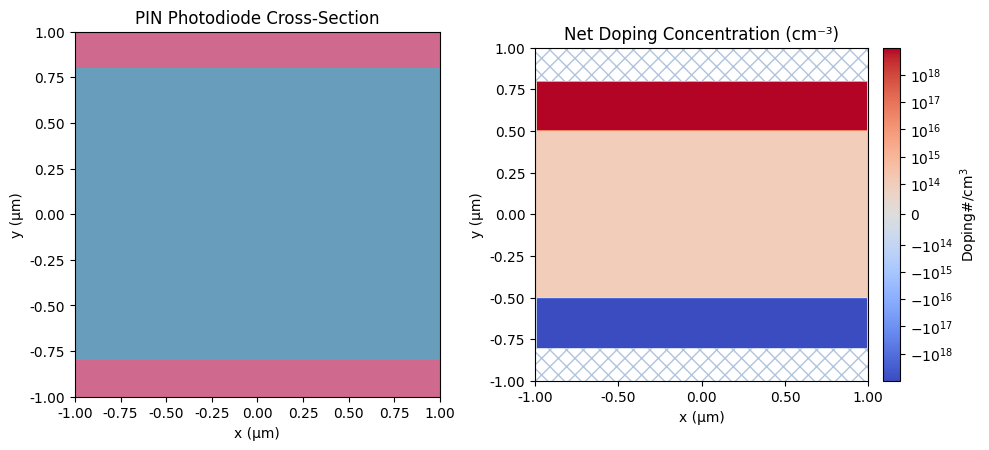

In [9]:
# Create scene for visualization
scene = td.Scene(structures=structures, medium=air)

# Plot geometry and doping
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot structure geometry
scene.plot(z=0, ax=ax1)
ax1.set_title("PIN Photodiode Cross-Section")
ax1.set_xlabel("x (µm)")
ax1.set_ylabel("y (µm)")

# Plot doping profile
scene.plot_structures_property(z=0, property="doping", ax=ax2, scale="symlog")
ax2.set_title("Net Doping Concentration (cm⁻³)")
ax2.set_xlabel("x (µm)")
ax2.set_ylabel("y (µm)")

plt.tight_layout()
plt.show()

### Boundary conditions and SSAC analysis setup

Now we define the electrical boundary conditions for the SSAC analysis:

1. **Cathode (N-contact)**: Grounded at 0V.
2. **Anode (P-contact)**: SSAC analysis voltage source with DC bias and small-signal perturbation.

We apply a **reverse bias** to the photodiode to:
- Deplete the intrinsic region.
- Create a strong electric field for fast carrier collection.
- Minimize junction capacitance.


In [10]:
# DC bias voltages for reverse bias operation
reverse_bias_voltages = [-2]  # -2V reverse bias

# Small-signal amplitude (must be small for linear approximation)
ac_amplitude = 1e-3  # 1 mV perturbation

# Cathode: ground reference (N-contact)
bc_cathode = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.GroundVoltage()),
    placement=td.StructureStructureInterface(structures=["contact_n", "si_n_region"]),
)

# Anode: SSAC voltage source (P-contact)
bc_anode = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(
        source=td.SSACVoltageSource(voltage=reverse_bias_voltages, amplitude=ac_amplitude)
    ),
    placement=td.StructureStructureInterface(structures=["contact_p", "si_p_region"]),
)

boundary_specs = [bc_cathode, bc_anode]

### Frequency range for SSAC analysis

We define a logarithmic frequency sweep from 100 Mhz to 100 GHz to capture the frequency-dependent behavior.


In [11]:
# Frequency range for SSAC analysis (Hz)
freq_min = 1e8  # 100 Mhz
freq_max = 1e11  # 100 GHz
n_freqs_per_decade = 5  # Number of frequency points per decade

freq_range = td.FreqRange.from_freq_interval(freq_min, freq_max)
freqs = freq_range.sweep_decade(n_freqs_per_decade)

### Define Monitors

We set up monitors to record various quantities during the simulation.


In [12]:
# Monitor for free carrier concentration
carrier_monitor = td.SteadyFreeCarrierMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, td.inf), name="carriers", unstructured=True
)

# Monitor for electric potential
potential_monitor = td.SteadyPotentialMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, td.inf), name="potential", unstructured=True
)

monitors = [carrier_monitor, potential_monitor]

### Analysis and Solver Settings

We configure the SSAC analysis parameters and solver tolerance settings.


In [13]:
# Solver tolerance settings
charge_tolerance = td.ChargeToleranceSpec(
    rel_tol=1e-5,  # Relative tolerance
    abs_tol=1e16,  # Absolute tolerance (cm⁻³)
    max_iters=400,  # Maximum iterations
    ramp_up_iters=1,  # Ramping iterations for convergence
)

# SSAC analysis specification
analysis_spec = td.IsothermalSSACAnalysis(
    tolerance_settings=charge_tolerance,
    convergence_dv=0.1,  # Voltage convergence criterion (V)
    fermi_dirac=False,  # Use Maxwell-Boltzmann statistics (faster, adequate for moderate doping)
    temperature=300,  # Ambient temperature (K)
    freqs=freqs.tolist(),  # Frequency list for AC analysis
)

### Grid specification

We define the mesh for the simulation. A finer mesh near the junctions ensures accurate resolution of the space-charge regions where the electric field varies rapidly.


In [14]:
# Base mesh resolution
dl_bulk = 0.04  # Bulk mesh size (µm)
dl_interface = 0.015  # Interface mesh size (µm)

# Refined regions near P-I and I-N junctions
refinement_pi = td.GridRefinementRegion(
    center=(0, p_center_y - p_thickness / 2, 0),
    size=(device_width, 0.2, 0),
    dl_internal=dl_interface / 2,
    transition_thickness=dl_bulk * 10,
)

refinement_in = td.GridRefinementRegion(
    center=(0, n_center_y + n_thickness / 2, 0),
    size=(device_width, 0.2, 0),
    dl_internal=dl_interface / 2,
    transition_thickness=dl_bulk * 10,
)

# Grid specification
grid_spec = td.DistanceUnstructuredGrid(
    relative_min_dl=0,
    dl_interface=dl_interface,
    dl_bulk=dl_bulk * 20,
    distance_interface=2 * dl_interface,
    distance_bulk=6 * dl_interface,
    sampling=1000,
    uniform_grid_mediums=["Si_doped"],
    mesh_refinements=[refinement_pi, refinement_in],
)

### Create the Simulation

Finally, we assemble all components into a `HeatChargeSimulation` object.


In [15]:
# Simulation domain
sim_center = (0, 0, 0)
sim_size = (device_width * 1.2, total_height + 2 * contact_thickness + 0.2, 0)

# Create simulation
sim = td.HeatChargeSimulation(
    medium=air,
    structures=structures,
    size=sim_size,
    center=sim_center,
    boundary_spec=boundary_specs,
    analysis_spec=analysis_spec,
    monitors=monitors,
    grid_spec=grid_spec,
)

## Run the Simulation

Now we run the SSAC simulation using the Tidy3D backend solver. The simulation will first solve the DC problem at the specified bias voltage. Then, it will perform small-signal analysis at each frequency and extract AC current response.

In [16]:
results = web.run(sim)

11:57:29 CET Created task 'heat_charge_2025-12-09_11-57-28' with resource_id    
             'hec-f88de0e2-0f8a-465b-bd90-b94d7118d156' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

11:57:39 CET Estimated FlexCredit cost: 0.025. Minimum cost depends on task     
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

11:57:42 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:58:05 CET status = preprocess

11:59:00 CET starting up solver

             running solver

12:06:04 CET status = success

Output()

12:06:08 CET Loading simulation from simulation_data.hdf5

## Post-processing and results analysis

### Extract AC current data

The SSAC simulation provides complex-valued AC current  $I(v, f)$  as a function of DC bias voltage  $v$  and frequency $f$ . This current represents the device's small-signal response to the AC voltage perturbation.


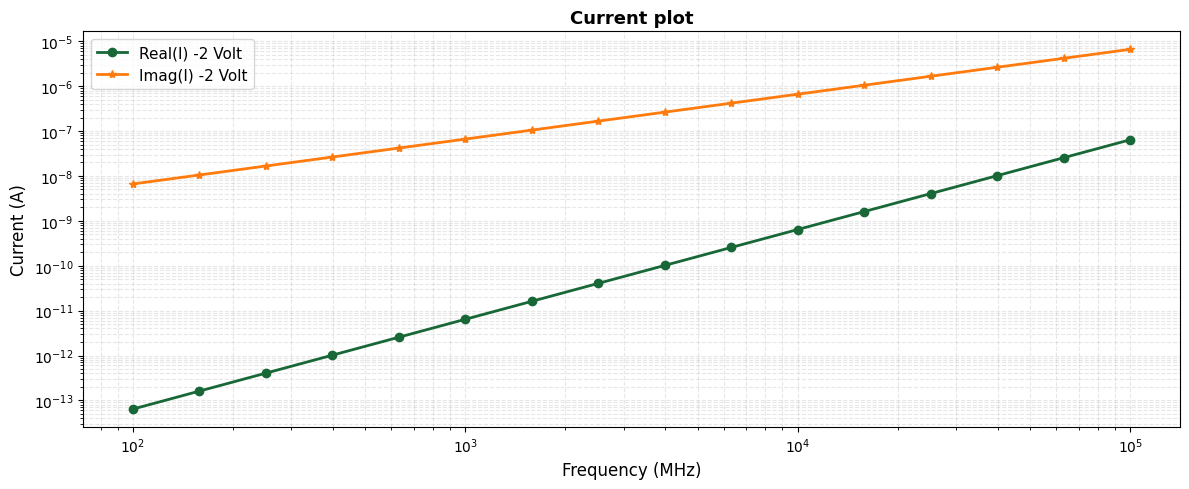

In [17]:
# Extract AC current-voltage data
ac_current = -results.device_characteristics.ac_current_voltage

# Get the bias voltage and frequency arrays
bias_voltage = reverse_bias_voltages[0]

frequencies = ac_current.coords["f"].values  # Frequency array

# Select current at the specified bias voltage
# Note: For 2D simulations, multiply by device depth to get total current
device_depth = 50  # µm (assuming device extends 50 µm in z-direction)
I_ac = ac_current.sel(v=bias_voltage).values * device_depth

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
# Plot conductance
ax.loglog(
    frequencies / 1e6,
    I_ac.real,
    "o-",
    linewidth=2,
    markersize=6,
    label=f"Real(I) {bias_voltage} Volt",
)
ax.loglog(
    frequencies / 1e6,
    I_ac.imag,
    "*-",
    linewidth=2,
    markersize=6,
    label=f"Imag(I) {bias_voltage} Volt",
)
ax.set_xlabel("Frequency (MHz)", fontsize=12)
ax.set_ylabel("Current (A)", fontsize=12)
ax.set_title("Current plot", fontsize=13, fontweight="bold")
ax.grid(True, which="both", alpha=0.3, linestyle="--")
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

### Calculate admittance, conductance, and capacitance

From the AC current  $I(\omega)$  and the applied AC voltage amplitude  $V_0$ , we calculate:

1. **Admittance**:  $Y(\omega)$ = $\frac{I(\omega)}{V_0} $

2. **Conductance**:  $G(\omega)$ = $\text{Re}[Y(\omega)]$  — represents resistive losses

3. **Capacitance**:  $C(\omega)$ = $\frac{\text{Im}[Y(\omega)]}{\omega}$  — represents charge storage

where  $\omega = 2\pi f$  is the angular frequency.


### Plot frequency-dependent conductance

Let's create a combined plot showing both conductance $G(f)$ and capacitance $C(f)$ to visualize the complete admittance behavior.

In [18]:
# Calculate admittance Y = I / V
Y = I_ac / ac_amplitude  # Admittance (S)

# Extract real and imaginary parts
G = np.real(Y)  # Conductance (S)
B = np.imag(Y)  # Susceptance (S)

# Calculate capacitance from susceptance: C = B / ω = B / (2πf)
omega = 2 * np.pi * frequencies  # Angular frequency (rad/s)
C = B / omega  # Capacitance (F)

# Convert to more convenient units
C_pF = C * 1e12  # Capacitance in pF
G_uS = G * 1e6  # Conductance in µS

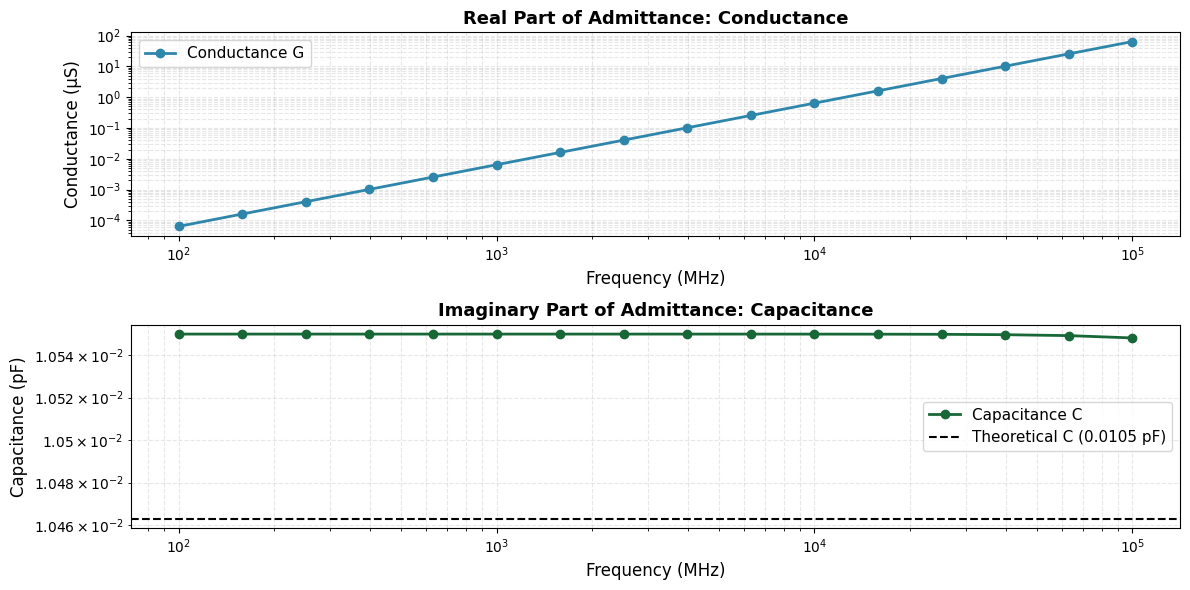

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot conductance
ax1.loglog(
    frequencies / 1e6, G_uS, "o-", linewidth=2, markersize=6, color="#2E86AB", label="Conductance G"
)
ax1.set_xlabel("Frequency (MHz)", fontsize=12)
ax1.set_ylabel("Conductance (µS)", fontsize=12)
ax1.set_title("Real Part of Admittance: Conductance", fontsize=13, fontweight="bold")
ax1.grid(True, which="both", alpha=0.3, linestyle="--")
ax1.legend(fontsize=11)

# Theoretical capacitance calculation
eps0 = 8.854e-18  # F/µm
eps_si = 11.7
area = (device_width + 2 * junction_width) * device_depth  # µm^2
width = i_thickness  # µm
C_theoretical = (td.EPSILON_0 * Si_medium.charge.permittivity * area) / width  # in Farads
C_theoretical_pF = C_theoretical * 1e12  # in pF

# Plot capacitance
ax2.loglog(frequencies / 1e6, C_pF, "o-", linewidth=2, markersize=6, label="Capacitance C")
ax2.axhline(
    y=C_theoretical_pF,
    color="k",
    linestyle="--",
    label=f"Theoretical C ({C_theoretical_pF:.4f} pF)",
)
ax2.set_xlabel("Frequency (MHz)", fontsize=12)
ax2.set_ylabel("Capacitance (pF)", fontsize=12)
ax2.set_title("Imaginary Part of Admittance: Capacitance", fontsize=13, fontweight="bold")
ax2.grid(True, which="both", alpha=0.3, linestyle="--")
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

In [20]:
print(
    f"Relative difference capacitance: {100 * np.abs((C_theoretical_pF - C_pF[0]) / C_theoretical_pF):.2f}%"
)

Relative difference capacitance: 0.83%


### Interpretation of results
The capacitance  $C(f)$  we observe is primarily the **junction capacitance** of the reverse-biased PIN diode. The SSAC analysis confirms that the device behaves as a geometric capacitor in this frequency regime. By extracting the imaginary part of the admittance ($C \approx \text{Im}(Y) / \omega$), we observe a frequency-independent capacitance. This indicates that the intrinsic region is fully depleted and acts effectively as a dielectric spacer between the doped contacts. The simulated value aligns with the analytical parallel-plate approximation $C \approx \epsilon_0 \epsilon_r A / W$, with a relative difference of less than 1%.

## Conclusion

In this notebook, we have showcased the Tidy3d capabilities through the following tasks:

1. **Defined the geometry of a silicon PIN photodiode** with realistic doping profiles and material parameters.
2. **Set up and performed Small-Signal AC (SSAC) analysis** using small-signal analysis framework.
3. **Extracted frequency-dependent device parameters** including conductance $G(f)$ and capacitance $C(f)$. 